# TinyML - Binomial Logistic Regression

## 1. Importing libraries

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import  roc_curve, auc, log_loss
from sklearn.model_selection import cross_validate

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

## 2. Load Dataset

The Iris dataset is a classic dataset in the field of machine learning and statistics. It was introduced by Sir Ronald A. Fisher in 1936 as an example of discriminant analysis. The dataset is often used for educational purposes and is a common starting point for the practice of pattern classification.


Attributes:

- Sepal length (in centimeters)

- Sepal width (in centimeters)

- Petal length (in centimeters)

- Sepal width (in centimeters)


Species:

- 0 - Setosa

- 1 - Versicolor

In [2]:
# Load iris dataset
data = load_iris()

# Create a DataFrame
df_iris = pd.DataFrame(data.data, columns=data.feature_names)


# Add target variable to the DataFrame
df_iris['target'] = data.target

# Remove NaN values
df = df_iris.dropna(axis='rows') #remove NaN

# Display the DataFrame
print(df_iris.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [3]:
df=df_iris.iloc[:100,0:4]

In [4]:
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
X=df.to_numpy()

# Converting string value to int type for labels: Setosa = 0, Versicolor = 1
y=df_iris.iloc[:100,-1]
y = LabelEncoder().fit_transform(y)

## 3. Dataset Visualization 

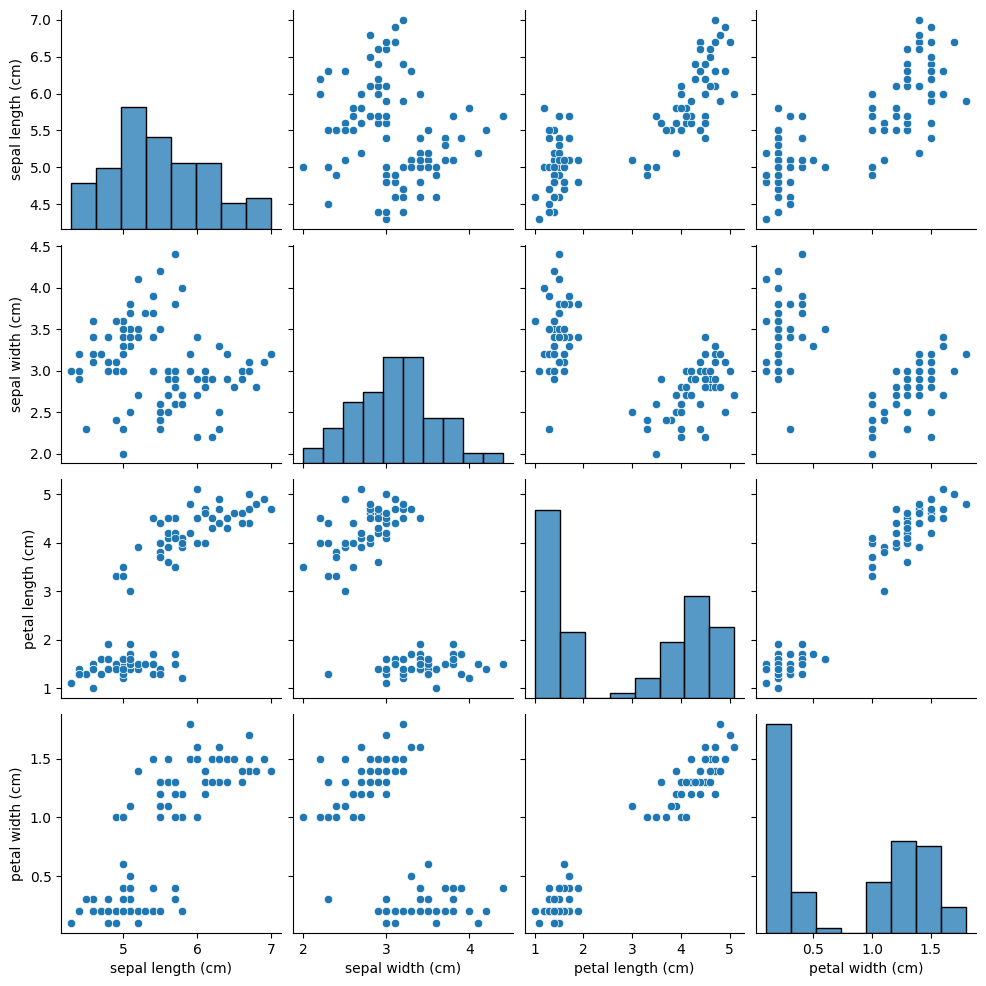

In [143]:
sns.pairplot(df)

## 4. Logistic Regression

### 4.1 Feature selection

#### 4.1.1 Recursive feature elimination

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [144]:
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(estimator=model, n_features_to_select=4, step=30)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(df.columns[rfe.support_]))

Selected features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


#### 4.1.2. Feature ranking with recursive feature elimination and cross-validation

RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. Hereafter a recursive feature elimination applied on logistic regression with automatic tuning of the number of features selected with cross-validation.

Optimal number of features: 1
Selected features: ['petal length (cm)']


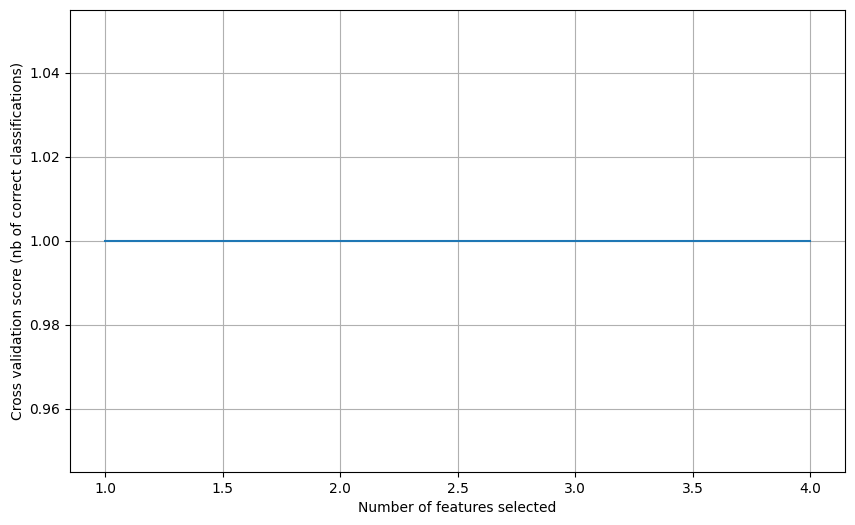

In [145]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(df.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.grid()
plt.show()

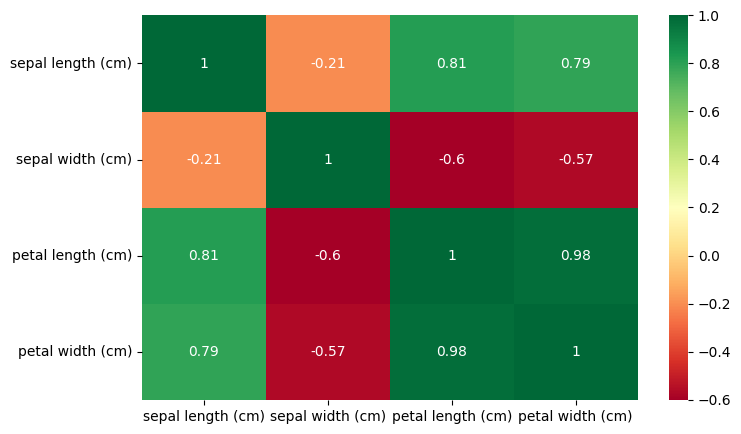

In [146]:
selected_features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']

df_selected = df[selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(df_selected.corr(), annot=True, cmap="RdYlGn")
plt.show()

### 4.2 Model evaluation

#### 4.2.1 Model evaluation based on simple train/test 

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [148]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)


In [149]:
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 1.000
LogisticRegression log_loss is 0.027
LogisticRegression auc is 1.000


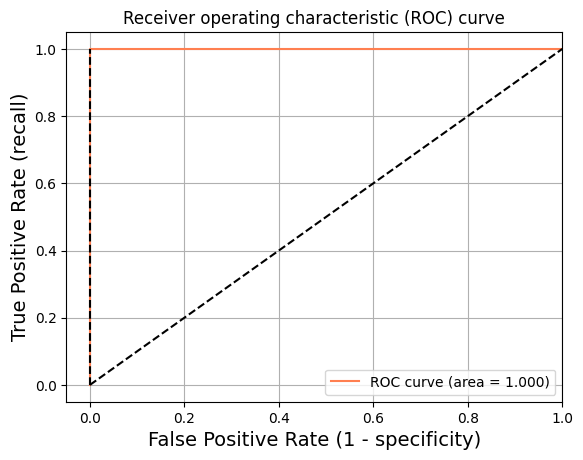

Using a threshold of 0.926 guarantees a sensitivity of 1.000 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [150]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1 - fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx]) * 100))


#### 4.2.2 Model evaluation based on K-fold cross-validation

In [151]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 1.000 (+/-0.000)
LogisticRegression average log_loss: 0.025 (+/-0.009)
LogisticRegression average auc: 1.000 (+/-0.000)


#### 4.2.3 GridSearchCV evaluating using multiple scorers simultaneously

In [152]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

In [153]:
print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=1e-05)
best params: {'C': 1e-05}
best score: 1.0


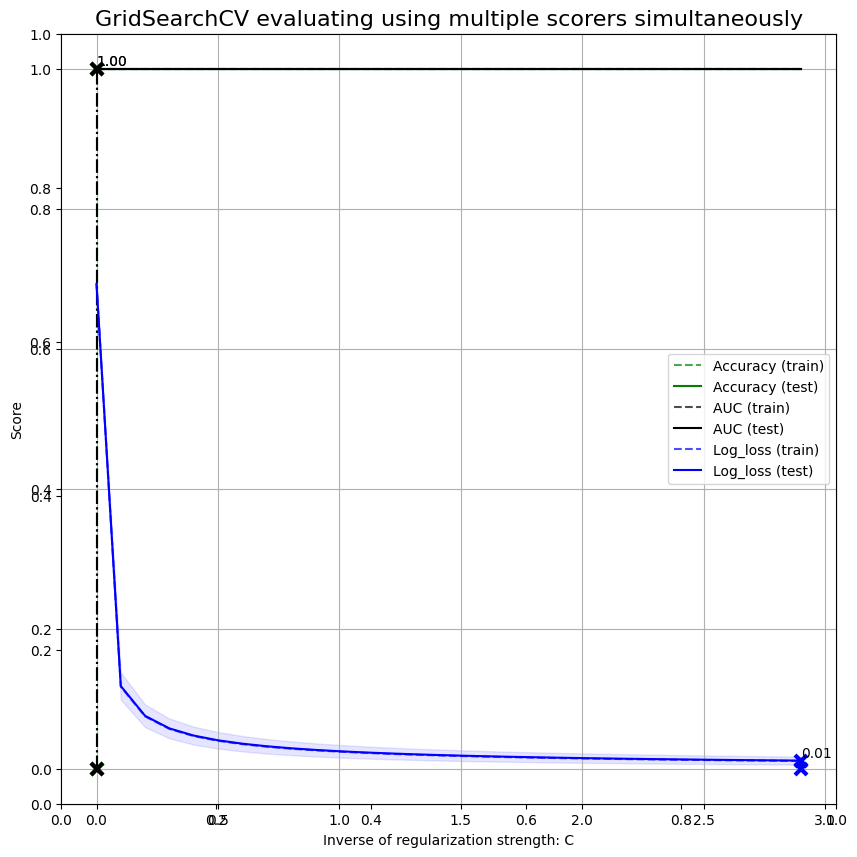

In [154]:
plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
#ax.set_xlim(0, param_grid['C'].max()) 
#ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

## 5. Obtaining the model to be implemented in the microcontroller

In [155]:
best_model = LogisticRegression(C=gs.best_score_)

In [156]:
best_model.fit(X_train, y_train)

LogisticRegression()

In [157]:
def generate_cpp_code(intercept, coefficients, threshold:float=0.5):
    cpp_code = "namespace Eloquent {\n"
    cpp_code += "namespace ML {\n"
    cpp_code += "namespace Port {\n"
    cpp_code += "class LogisticRegressor {\n"
    cpp_code += "public: \n\n"

    cpp_code += "float predict(float *x) { \n"
    cpp_code += "float probability = 0;\n"


    cpp_code += f"float coefficients[{len(coefficients)}] = "
    cpp_code += "{" + ", ".join(map(str, coefficients)) + "};\n\n"

    cpp_code += f"    float z = {intercept};\n"
    cpp_code += f"    for (int i = 0; i < {len(coefficients)}; i++)\n"
    cpp_code += "     {\n"
    cpp_code += f"       z += coefficients[i] * x[i];\n"
    cpp_code += "     }\n\n"              
    cpp_code += "probability = 1 / (1 + exp(-1*z));  \n" 
    
    cpp_code += f"if (probability >= {threshold}) \n" 
    cpp_code += "{ return 1; \n"
    cpp_code += "} else { \n"
    cpp_code += "return 0; \n"
    cpp_code += "} \n"
    cpp_code += "} \n"

    cpp_code += "};\n"

    cpp_code += "}\n"
    cpp_code += "}\n"
    cpp_code += "}\n"    
    return cpp_code

In [158]:
# Retrieve coefficients and intercept
coefficients = best_model.coef_[0]
intercept = best_model.intercept_[0]

In [166]:
print('coefficients:', coefficients)
print('intercept:', intercept)

coefficients: [ 0.37895195 -0.86498894  2.20391073  0.91466093]
intercept: -6.01143820166656


In [159]:
cpp_code = generate_cpp_code(intercept, coefficients)

## 6. Saves the template in a .h file

In [167]:
with open('./LogisticRegressor/LogisticRegressor.h', 'w') as file:
    file.write(cpp_code)

FileNotFoundError: [Errno 2] No such file or directory: './LogisticRegressor/LogisticRegressor.h'